In [16]:
import os
import glob
import sys
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

# user path:
usrname = getpass.getuser()
# add paths:
sys.path.append(f'/Users/{usrname}/Desktop/Projects')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/bimanual_wrist')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/Functional_Fusion')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/PcmPy')

import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
from PcmPy.tmp__inference_cka import fit_CKA_individ, fit_CKA_group_crossval
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# Load data

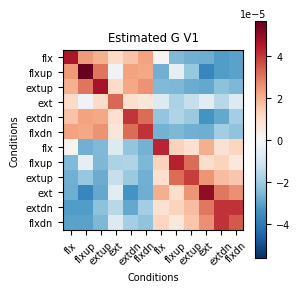

In [35]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'V1'
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
labels_lateral = ['contra']*6 + ['ipsi']*6
cmap = 'RdBu_r'
ncond = 12

# load dataset:
file_path_save = os.path.join(analysisDir, f'pcm_dataset_12by12_{region}.npz')
D = np.load(file_path_save, allow_pickle=True)
D = D['Y'].tolist()

# data g matrix:
N = len(D)
G_hat = np.zeros((N, ncond, ncond))
Dist = np.zeros((N,ncond,ncond))
for i in range(N):
    G_hat[i, :, :], _ = pcm.est_G_crossval(D[i].measurements,
                                            D[i].obs_descriptors['cond_vec'],
                                            D[i].obs_descriptors['part_vec'],
                                            X=pcm.matrix.indicator(D[i].obs_descriptors['part_vec']))

plt.rcParams.update({'font.size': 7})
# visualize the estimated G:
G_mean = np.mean(G_hat, axis=0)
plt.figure(figsize=(3,3))
vmin = -np.max(np.abs(G_mean))
vmax = np.max(np.abs(G_mean))
plt.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(f'Estimated G {region}')
plt.xlabel('Conditions')
plt.ylabel('Conditions')
plt.xticks(ticks=np.arange(ncond), labels=labels, rotation=45)
plt.yticks(ticks=np.arange(ncond), labels=labels)
plt.tight_layout()
plt.show()



# Single Subjects

## Build models

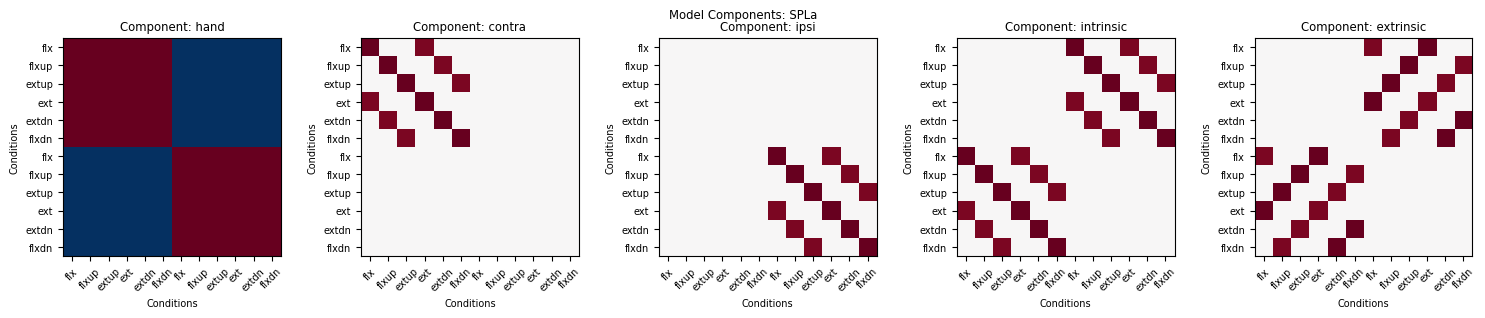

In [12]:
file_path = os.path.join(analysisDir, f'best_within_model_{region}.npz')
data = np.load(file_path)
G_mdl = data['G_hat']
# G_mdl = pcm.centering(ncond) @ G_mdl @ pcm.centering(ncond)
G_mdl = G_mdl / np.trace(G_mdl)

G_model = {}

# hand component:
cov = np.zeros((ncond, ncond))
cov[0:6,0:6] = 1
cov[6:12,6:12] = 1
cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
cov = cov / np.trace(cov)
G_model['hand'] = cov

# contra hand:
C = G_mdl
cov = np.zeros((ncond, ncond))
cov[0:6,0:6] = C
G_model['contra'] = cov

# ipsi hand:
cov = np.zeros((ncond, ncond))
cov[6:12,6:12] = C
G_model['ipsi'] = cov

# intrinsic:
cov = np.zeros((ncond, ncond))
cov[0:6,6:12] = C
cov[6:12,0:6] = C.T
G_model['intrinsic'] = cov

# extrinsic:
cov = np.zeros((ncond, ncond))
C_ext = C[:, [3,2,1,0,5,4]]
cov[0:6,6:12] = C_ext
cov[6:12,0:6] = C_ext.T
G_model['extrinsic'] = cov

Mcomponents = pcm.ComponentModel('trueG', [G_model['hand'], G_model['contra'], G_model['ipsi'], G_model['intrinsic'], G_model['extrinsic']])

# visualize model components:
ncomponent = len(G_model.keys())
fig, axes = plt.subplots(1, ncomponent, figsize=(3*ncomponent,3))
for i, key in enumerate(G_model.keys()):
    vmin = -np.max(np.abs(G_model[key]))
    vmax = np.max(np.abs(G_model[key]))
    axes[i].imshow(G_model[key], cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axes[i].set_title(f'Component: {key}')
    axes[i].set_xlabel('Conditions')
    axes[i].set_ylabel('Conditions')
    axes[i].set_xticks(ticks=np.arange(ncond), labels=labels, rotation=45)
    axes[i].set_yticks(ticks=np.arange(ncond), labels=labels)
plt.suptitle(f'Model Components: {region}')
plt.tight_layout()
plt.show()



## Fit CKA

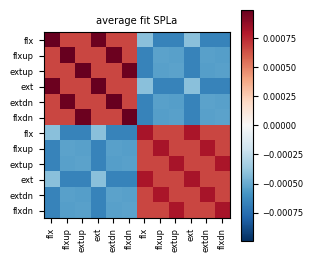

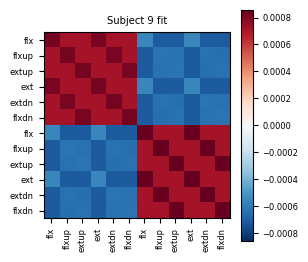

[1.         0.33813302 0.36739876 0.18174852 0.15687092]


/Users/aghavamp/Desktop/Projects/bimanual_wrist/.conda/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 45.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


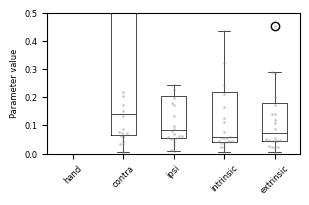

In [13]:
N = len(D)
M = [Mcomponents]

T, theta = fit_CKA_individ(D, M, fixed_effect='block', theta0=None, verbose = False)
# print(theta)

nmodels = len(M)
# set font:
matplotlib.rcParams.update({'font.size': 6})
# Plot model predictions:
fig, ax = plt.subplots(1, figsize=(3,3))
G_pred = np.zeros((N, ncond, ncond))
for i in range(N):
    th = theta[0][:,i]
    G_pred[i,:,:] = M[0].predict(th[:M[0].n_param])[0]

G_mean = np.mean(G_pred, axis=0)
vmin = -np.max(np.abs(G_mean))
vmax = np.max(np.abs(G_mean))
ax.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax.set_xticks(list(range(12)))
ax.set_xticklabels(labels, rotation=90)
ax.set_yticks(list(range(12)))
ax.set_yticklabels(labels)
ax.set_title(f'average fit {region}')
plt.colorbar(ax.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=ax)
plt.show()

# model fit for a subject:
# Plot model predictions:
fig, ax = plt.subplots(1, figsize=(3,3))
# th = np.mean(theta[i], axis=1)
n = np.random.randint(0, N)
G = G_pred[n,:,:]
vmin = -np.max(np.abs(G))
vmax = np.max(np.abs(G))
ax.imshow(G, cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax.set_xticks(list(range(12)))
ax.set_xticklabels(labels, rotation=90)
ax.set_yticks(list(range(12)))
ax.set_yticklabels(labels)
ax.set_title(f'Subject {n} fit')
plt.colorbar(ax.imshow(G, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=ax)
plt.show()

# boxplot of parameters across subject:
th = np.exp(theta[0])
th = th/th[0,:]
print(np.mean(th,axis=1))

fig, ax = plt.subplots(1, figsize=(3,2))
sns.boxplot(data=pd.DataFrame(th.T, columns=['hand', 'contra', 'ipsi', 'intrinsic', 'extrinsic']), ax=ax, color='k', fill=False, width=0.5, linewidth=0.5)
sns.swarmplot(data=pd.DataFrame(th.T, columns=['hand', 'contra', 'ipsi', 'intrinsic', 'extrinsic']), ax=ax, color='gray', size=2, alpha=0.4)
plt.xticks(rotation=45)
plt.ylabel('Parameter value')
plt.tight_layout()
plt.ylim((0,0.5))
plt.show()




# Group Cross Val

## Build Models

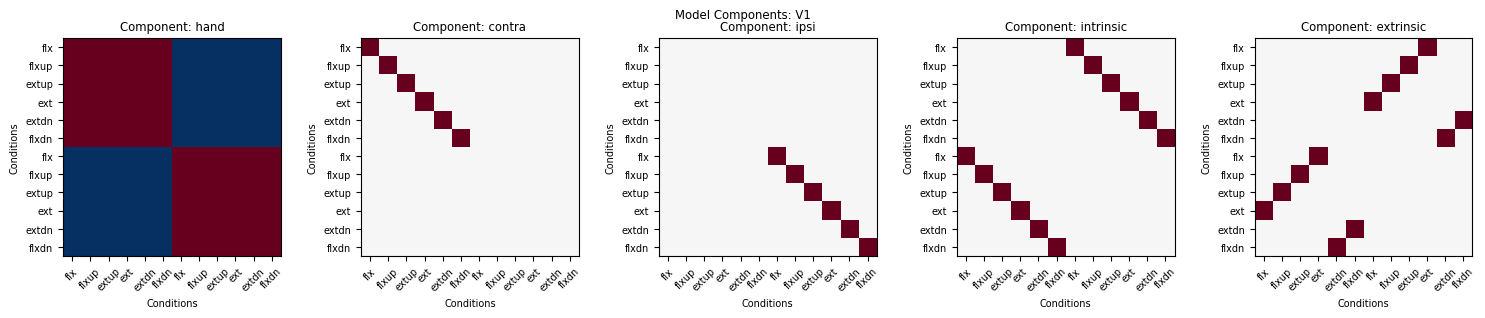

In [36]:
file_path = os.path.join(analysisDir, f'best_within_model_{region}.npz')
data = np.load(file_path)
G_mdl = data['G_hat']
G_model = {}

# hand component:
cov = np.zeros((ncond, ncond))
cov[0:6,0:6] = 1
cov[6:12,6:12] = 1
cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
cov = cov / np.trace(cov)
G_model['hand'] = cov

# contra hand:
C = G_mdl
cov = np.zeros((ncond, ncond))
cov[0:6,0:6] = C
G_model['contra'] = cov

# ipsi hand:
cov = np.zeros((ncond, ncond))
cov[6:12,6:12] = C
G_model['ipsi'] = cov

# intrinsic:
cov = np.zeros((ncond, ncond))
cov[0:6,6:12] = C
cov[6:12,0:6] = C.T
G_model['intrinsic'] = cov

# extrinsic:
cov = np.zeros((ncond, ncond))
C_ext = C[:, [3,2,1,0,5,4]]
cov[0:6,6:12] = C_ext
cov[6:12,0:6] = C_ext.T
G_model['extrinsic'] = cov

M = []
M.append(pcm.ComponentModel('contra', [G_model['hand'], G_model['contra']]))
M.append(pcm.ComponentModel('Base', [G_model['hand'], G_model['contra'], G_model['ipsi']]))
M.append(pcm.ComponentModel('Intrinsic', [G_model['hand'], G_model['contra'], G_model['ipsi'], G_model['intrinsic']]))
M.append(pcm.ComponentModel('Extrinsic', [G_model['hand'], G_model['contra'], G_model['ipsi'], G_model['extrinsic']]))
M.append(pcm.ComponentModel('Full', [G_model['hand'], G_model['contra'], G_model['ipsi'], G_model['intrinsic'], G_model['extrinsic']]))

# visualize model components:
ncomponent = len(G_model.keys())
fig, axes = plt.subplots(1, ncomponent, figsize=(3*ncomponent,3))
for i, key in enumerate(G_model.keys()):
    vmin = -np.max(np.abs(G_model[key]))
    vmax = np.max(np.abs(G_model[key]))
    axes[i].imshow(G_model[key], cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axes[i].set_title(f'Component: {key}')
    axes[i].set_xlabel('Conditions')
    axes[i].set_ylabel('Conditions')
    axes[i].set_xticks(ticks=np.arange(ncond), labels=labels, rotation=45)
    axes[i].set_yticks(ticks=np.arange(ncond), labels=labels)
plt.suptitle(f'Model Components: {region}')
plt.tight_layout()
plt.show()



## Fit CKA CV

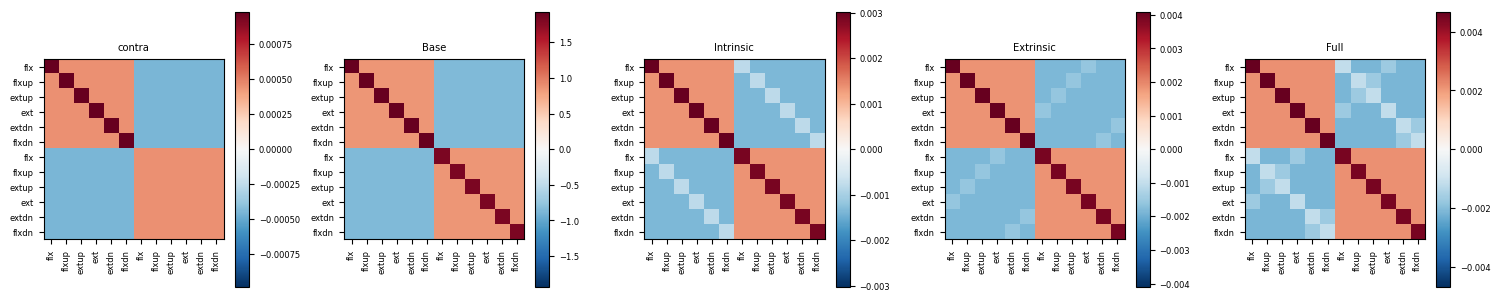

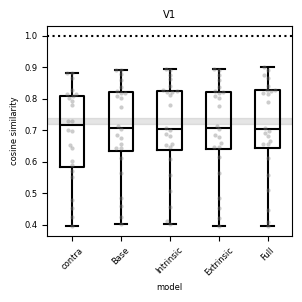

T-test Base > contra: t(23)=3.482, p=0.0010
T-test Intrinsic > Base: t(23)=1.499, p=0.0737
T-test Extrinsic > Base: t(23)=1.449, p=0.0804
T-test Full > Intrinsic: t(23)=1.755, p=0.0462
T-test Full > Extrinsic: t(23)=1.758, p=0.0460
Best model based on mean CKA: Full
Best model based on mean AIC: contra


In [37]:
N = len(D)

T_ind, theta_ind, AIC = fit_CKA_individ(D, M, fixed_effect='block', theta0=None, verbose = False, AIC=True)
T, theta, ceil = fit_CKA_group_crossval(D, M, fixed_effect='block', theta0=None, verbose = False, ceil=True)

# set font:
matplotlib.rcParams.update({'font.size': 6})
nmodels = len(M)
fig, ax = plt.subplots(1, nmodels, figsize=(nmodels*3,3))
th = []
for m in range(nmodels):
    th_tmp = np.exp(theta[m])
    th_tmp = np.median(th_tmp, axis=1)
    th_tmp = np.log(th_tmp)
    th.append(th_tmp)
    
    G_pred = M[m].predict(th[m][:M[m].n_param])[0]
    vmin = -np.max(np.abs(G_pred))
    vmax = np.max(np.abs(G_pred))
    ax[m].imshow(G_pred, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    ax[m].set_xticks(list(range(ncond)))
    ax[m].set_xticklabels(labels, rotation=90)
    ax[m].set_yticks(list(range(ncond)))
    ax[m].set_yticklabels(labels)
    ax[m].set_title(f'{M[m].name}')
    plt.colorbar(ax[m].imshow(G_pred, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=ax[m])
plt.tight_layout()
plt.show()

# Convert MultiIndex columns to long form
# Stack the *model* level, so models become rows
T_long = (
    T.stack(level='model', future_stack=True)        # move model into the index
      .reset_index()              # index -> columns
      .melt(id_vars=['level_0', 'model'],
            var_name='metric',
            value_name='value')
)
T_long

# boxplot CKA:
T_cka = T_long[T_long['metric'] == 'CKA'].copy()
ceil_high = np.mean(ceil['ceil_high'])
ceil_low = np.mean(ceil['ceil_low'])
plt.figure(figsize=(3,3))
sns.boxplot(data=T_cka, x='model', y='value', color='k', fill=False, width=0.5, order=['contra','Base', 'Intrinsic', 'Extrinsic', 'Full'])
sns.swarmplot(data=T_cka, x='model', y='value', color='gray', size=3, alpha=0.4, order=['contra','Base', 'Intrinsic', 'Extrinsic', 'Full'])
plt.axhline(y=1, color='black', linestyle=':')
# make a zone for ceiling:
plt.axhspan(ceil_low, ceil_high, color='gray', alpha=0.2, label='Ceiling')
plt.xticks(rotation=45)
plt.ylabel('cosine similarity')
plt.title(f'{region}')
plt.tight_layout()
# plt.ylim((0.8, 1.05))
plt.show()

# t-test
m0 = 'contra'
m1 = 'Base'
m2 = 'Intrinsic'
m3 = 'Extrinsic'
m4 = 'Full'
T_cka.loc[:, 'value_ztrans'] = np.arctanh(T_cka['value'])  # Fisher z-transform

# m1 > m0:
data1 = T_cka[T_cka['model'] == m0]['value']
data2 = T_cka[T_cka['model'] == m1]['value']
tstat, pval = stats.ttest_rel(data2, data1, alternative='greater')
print(f'T-test {m1} > {m0}: t({len(data2)-1})={tstat:.3f}, p={pval:.4f}')

# m2 > m1:
data1 = T_cka[T_cka['model'] == m1]['value']
data2 = T_cka[T_cka['model'] == m2]['value']
tstat, pval = stats.ttest_rel(data2, data1, alternative='greater')
print(f'T-test {m2} > {m1}: t({len(data2)-1})={tstat:.3f}, p={pval:.4f}')

# m3 > m1:
data1 = T_cka[T_cka['model'] == m1]['value']
data2 = T_cka[T_cka['model'] == m3]['value']
tstat, pval = stats.ttest_rel(data2, data1, alternative='greater')
print(f'T-test {m3} > {m1}: t({len(data2)-1})={tstat:.3f}, p={pval:.4f}')

# m4 > m2:
data1 = T_cka[T_cka['model'] == m2]['value']
data2 = T_cka[T_cka['model'] == m4]['value']
tstat, pval = stats.ttest_rel(data2, data1, alternative='greater')
print(f'T-test {m4} > {m2}: t({len(data2)-1})={tstat:.3f}, p={pval:.4f}')

# m4 > m3:
data1 = T_cka[T_cka['model'] == m3]['value']
data2 = T_cka[T_cka['model'] == m4]['value']
tstat, pval = stats.ttest_rel(data2, data1, alternative='greater')
print(f'T-test {m4} > {m3}: t({len(data2)-1})={tstat:.3f}, p={pval:.4f}')

# pick best model based on median CKA:
mean_cka = T_cka.groupby('model')['value'].mean()
best_model = mean_cka.idxmax()
# best_model = 'Full'
print(f'Best model based on mean CKA: {best_model}')

# save the best G:
i = [idx for idx, m in enumerate(M) if m.name == best_model][0]
G_pred = M[i].predict(th[i][:M[i].n_param])[0]
file_path_save = os.path.join(analysisDir, f'best_unimanual_model_{region}.npz')
np.savez(file_path_save, G_hat=G_pred)

# best model based on AIC:
AIC_flat  = AIC.melt(var_name='model', value_name='AIC')
mean_aic = AIC_flat.groupby('model')['AIC'].mean()
best_model_aic = mean_aic.idxmin()
print(f'Best model based on mean AIC: {best_model_aic}')



# Plot G_hat

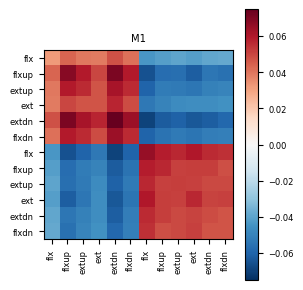

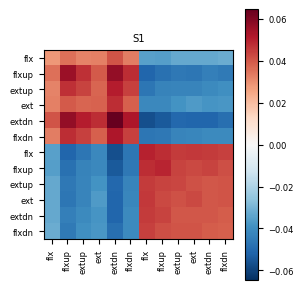

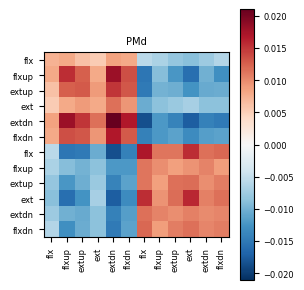

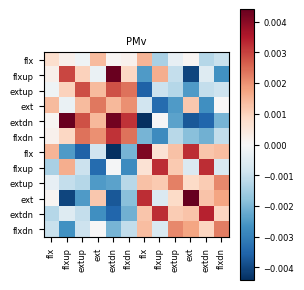

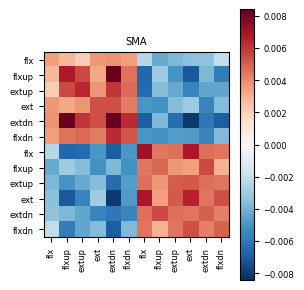

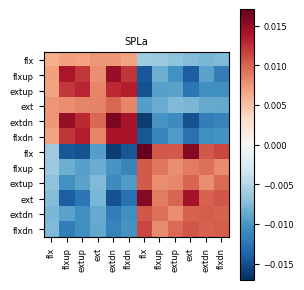

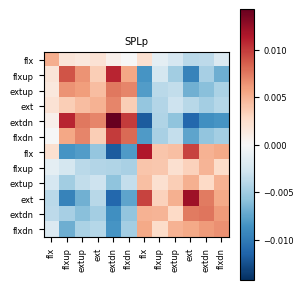

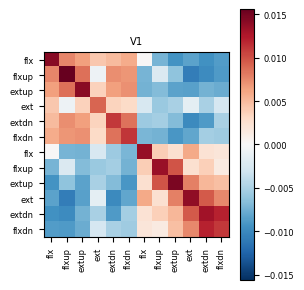

In [19]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'M1'
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
labels_lateral = ['contra']*6 + ['ipsi']*6
cmap = 'RdBu_r'
ncond = 12

for region in regions:
    # load dataset:
    file_path_save = os.path.join(analysisDir, f'pcm_dataset_12by12_{region}.npz')
    D = np.load(file_path_save, allow_pickle=True)
    D = D['Y'].tolist()

    # data g matrix:
    N = len(D)
    G_hat = np.zeros((N, ncond, ncond))
    for i in range(N):
        G_hat[i, :, :], _ = pcm.est_G_crossval(D[i].measurements,
                                                D[i].obs_descriptors['cond_vec'],
                                                D[i].obs_descriptors['part_vec'],
                                                X=pcm.matrix.indicator(D[i].obs_descriptors['part_vec']))

    # PLOT:
    matplotlib.rcParams.update({'font.size': 6})
    fig, ax = plt.subplots(1, 1, figsize=(3,3))
    G_mean = np.mean(G_hat, axis=0)
    vmin = -np.max(np.abs(G_mean))
    vmax = np.max(np.abs(G_mean))
    ax.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    ax.set_xticks(list(range(ncond)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticks(list(range(ncond)))
    ax.set_yticklabels(labels)
    ax.set_title(f'{region}')
    plt.colorbar(ax.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=ax)
    plt.tight_layout()
    plt.show()

    # fig, ax = plt.subplots(1, 1, figsize=(2,2))
    # tmp = G_mean[6:12, 6:12]
    # tmp = tmp - tmp.mean(axis=0, keepdims=True) - tmp.mean(axis=1, keepdims=True) + tmp.mean()
    # # tmp = tmp + np.ones_like(tmp)/100
    # # double center:
    # vmin = -np.max(np.abs(tmp))
    # vmax = np.max(np.abs(tmp))
    # ax.imshow(tmp, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    # ax.set_xticks(list(range(6)))
    # ax.set_yticks(list(range(6)))
    # ax.set_title(f'{region}')
    # plt.colorbar(ax.imshow(tmp, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=ax)
    # plt.tight_layout()
    # plt.show()

